# Dot calling

Welcome to the dot calling notebook!

Dot calling finds significantly enriched interactions in the Hi-C map. 
The traditional algorithm for that is HICCUPS (proposed in [Rao et al. 2014](https://doi.org/10.1016/j.cell.2014.11.021). However, the original HICCUPS is written in Java, making it hard to modify the parameters and specific steps.

We implement dot caller in Python and make it easy to control the parameter and processing steps for flexible search of optimal parameters for new Hi-C or Micro-C datasets.

In [1]:
# Setup the environment first: TODO: do we need it with the api update? 
# read: https://github.com/mirnylab/cooler/issues/138 for more details:
# !export MKL_NUM_THREADS=1 - # not working in a notebook ((
# instead do this, after making sure mkl is installed
import mkl
mkl.set_num_threads(1)
from threadpoolctl import threadpool_info
threadpool_info();

In [2]:
# Data processing/manupulation imports: 
import os.path as op
import pandas as pd
import numpy as np
from itertools import chain

# Hi-C utilities imports: 
import cooler
import bioframe
import cooltools
import bioframe
from cooltools import dots
from cooltools import numutils

# Visualization imports: 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.ticker import EngFormatter

bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

## Load data

For dot calling, we need input cool file with Hi-C data, regions for calculation of expected (chromosomes or chromosome arms).

In [58]:
# Download the test data from osf and define cooler:
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')
# 10 kb is a resolution at which one can clearly see "dots":
binsize = 10_000
# Open cool file with Micro-C data:
clr = cooler.Cooler(f'./test.mcool::/resolutions/{binsize}')

#### define genomic view that will be used to call dots and pre-compute expected

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
hg38_arms = hg38_arms.set_index("chrom").loc[clr.chromnames].reset_index()

# intra-arm expected
expected = cooltools.expected_cis(
    clr,
    view_df=hg38_arms,
    nproc=4,
)

## Perform dot-calling with default parameters

In the original HICCUP algorithm, there is a number of parameters that can be varied for the better fit to your data.
Here, we can call the algorithm with near default parameters

In [7]:
dots_df = dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 23.099 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 186 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 186 tile

### Demonstrate the results of dot-calling with the default parameters

In [25]:
# create a functions that would return a series of rectangles around called dots
# in a specific region, and exposing importnat plotting parameters

def rectangles_around_dots(df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangle around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2")
    )
    kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1,s2,e1,e2 in df_reg[["start1","start2","end1","end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")


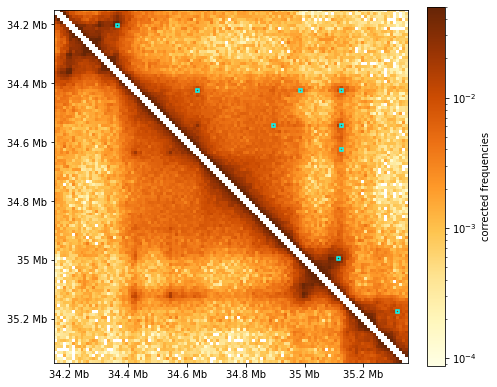

In [55]:
# define a region to look into as an example
start = 34_150_000
end = start + 1_200_000
region = ('chr17', start, end)

# heatmap kwargs
matshow_kwargs = dict(
    cmap='YlOrBr',
    norm=LogNorm(vmax=0.05),
    extent=(start, end, end, start)
)

# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')

# compute heatmap for the region
region_matrix = clr.matrix(balance=True).fetch(region)
for diag in [-1,0,1]:
    region_matrix = numutils.fill_diag(region_matrix, np.nan, i=diag)

# see viz.ipynb for details of heatmap visualization
f, ax = plt.subplots(figsize=(7,7))
im = ax.matshow( region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for box in rectangles_around_dots(dots_df, region, lw=1.5):
    ax.add_patch(box)


### Skipping clustering and strict enrichment filtering
Dot-calling is searching for pixels that are enriched relative to some local background. Such pixels often come in groups ("clusters") and by default `dots` tries to pick a "nice" representative for each cluster - but users can easily turn clustering off for debugging or alternative clustering purposes:

In [10]:
dots_df_all = dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    max_loci_separation=10_000_000,
    clustering_radius=None,  # None - implies no clustering
    cluster_filtering=False,  # ignored when clustering is off
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 25.591 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 186 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 186 tile

Compare clustered dots (cyan) with all enriched pixels before clustering (blue)

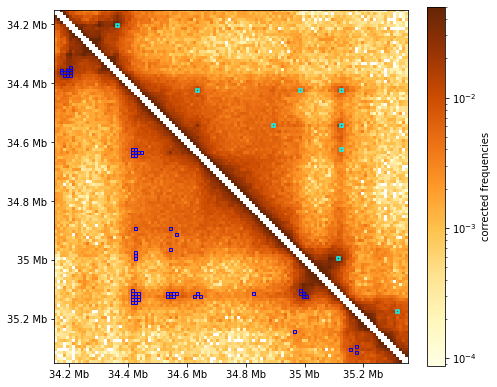

In [56]:
f, ax = plt.subplots(figsize=(7,7))
# draw heatmap
im = ax.matshow(region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in chain(
        rectangles_around_dots(dots_df, region, lw=1.5),  # clustered & filtered
        rectangles_around_dots(dots_df_all, region, loc="lower", ec="blue"),  # unclustered
    ):
    ax.add_patch(rect)

## Called dots are enriched relative to local background

### Kernels used to define local enrichment of a pixel

 - Dots observed on Hi-C heatmaps as *small* and concentrated clusters of locally enriched pixels.
 - Biologically relevant sizes of such clusters and their surroundings are empirically defined at `~50kb` for the diameter of clusters, and `~100kb` for the diameter of the local surrounding
 - Several types of kernels (i.e. local environments) could be used to rule out unwanted enrichment types, e.g. elongated clusters, large corners, etc.
 - One can choose from pre-defined set of kernels from *Rao et al 2014*, or provide custome ones
 - Below, we prepare a function to "plot" kernels and will demonstrate default and modified versions

In [32]:
# function to draw kernels on a "checkeboard" to highlight involved pixels:
def draw_kernel(kernel, axis=None, cmap='viridis'):
    if axis is None:
        f, axis = plt.subplots()
    # kernel:
    imk = axis.imshow(
                    kernel[::-1,::-1],  # flip it, as in convolution
                    alpha=0.85,
                    cmap=cmap,
                    interpolation='nearest')
    # draw a square around the target pixel:
    x0 = kernel.shape[0] // 2 - 0.5
    y0 = kernel.shape[1] // 2 - 0.5
    rect = patches.Rectangle((x0, y0), 1, 1, lw=1, ec='r', fc='r')
    axis.add_patch(rect)

    # clean axis:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels('',visible=False)
    axis.set_yticklabels('',visible=False)
    axis.set_title("{} kernel".format(ktype),fontsize=16)
    # add a checkerboard to highlight pixels:
    checkerboard = np.add.outer(range(kernel.shape[0]),
                                range(kernel.shape[1])) % 2
    # show it:
    axis.imshow(checkerboard,
            cmap='gray',
            interpolation='nearest',
            alpha=0.3)

    return imk

#### draw default kernels used in HiCCUPS
local backgrounds are defined using kernels, where pixels that are included in the calculations are highlighted in yellow, pixel of interest is highglighted in red, and pixels that are not included in the local background are purple.
Checkerboard pattern overlayed on the figure to emphasize individual pixels.

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000


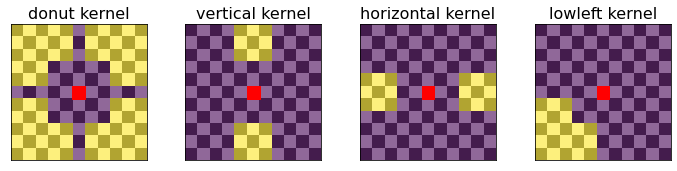

In [35]:
kernels = cooltools.api.dotfinder.recommend_kernels(binsize)

fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
for ax, (ktype, kernel) in zip(axs, kernels.items()):
    imk = draw_kernel(kernel, ax)

### Using same set of 4 kernels with more "rounded" donut

We can try to experiment with the kernels, e.g. by making them more round.
Again, kernels are defining the local area around a given pixel, that is used to test if a given pixel is enriched relative to it or not.

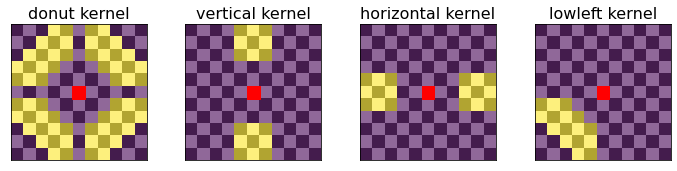

In [41]:
# create a grid of coordinates from -5 to 5, to define round kernels
# see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html for details
half = 5  # half width of the kernel
x, y = np.meshgrid(
    np.linspace(-half, half, 2*half + 1),
    np.linspace(-half, half, 2*half + 1),
)
# now define a donut-like mask as pixels between 2 radii: sqrt(7) and sqrt(30):
mask = (x**2+y**2 > 7) & (x**2+y**2 <= 30)
mask[:,half] = 0
mask[half,:] = 0

# lowleft mask - zero out neccessary parts
mask_ll = mask.copy()
mask_ll[:,:half] = 0
mask_ll[half:,:] = 0

# new kernels with more round donut and lowleft masks:
kernels_round = {'donut': mask,
 'vertical': kernels["vertical"].copy(),
 'horizontal': kernels["horizontal"].copy(),
 'lowleft': mask_ll}

# plot rounded kernels
fig, axs = plt.subplots(ncols=4, figsize=(12,2.5))
for ax, (ktype, kernel) in zip(axs, kernels_round.items()):
    imk = draw_kernel(kernel, ax)

#### call dots using redefined kernels (without clustering) ...

In [46]:
dots_round_df_all = dots(
    clr,
    expected=expected,
    view_df=hg38_arms,
    kernels=kernels_round, # provide custom kernels
    max_loci_separation=10_000_000,
    clustering_radius=None,
    nproc=4,
)

/home/sergpolly/Desktop/src/cooltools/cooltools/api/dotfinder.py:1565: UserWarning: Compatibility checks for 'kernels' are not fully implemented yet, use at your own risk
  warnings.warn(
INFO:root: matrix 9314X9314 to be split into 361 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 14907X14907 to be split into 900 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 2472X2472 to be split into 25 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root: matrix 5855X5855 to be split into 144 tiles of 500X500.
INFO:root: tiles are padded (width=5) to enable convolution near the edges
INFO:root:convolving 186 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 186 tiles
INFO:root:Done building histograms in 32.922 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:ro

Compare dots called using "rounded" kernels (cyan) with the dots called using recommended kernels (blue). As one can tell the results are similar, yet the "rounded" kernels allow for calling dots closer to the diagonal because of the shape of the kernel.

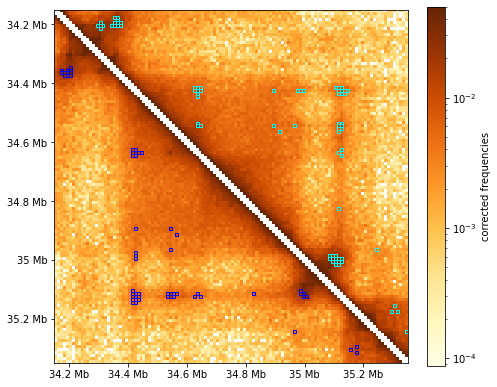

In [57]:
f, ax = plt.subplots(figsize=(7,7))
# draw heatmap
im = ax.matshow(region_matrix, **matshow_kwargs)
format_ticks(ax, rotate=False)
plt.colorbar(im, ax=ax, **colorbar_kwargs)

# draw rectangular "boxes" around pixels called as dots in the "region":
for rect in chain(
        rectangles_around_dots(dots_round_df_all, region),
        rectangles_around_dots(dots_df_all, region, loc="lower", ec="blue"),
    ):
    ax.add_patch(rect)

In [ ]:
# TODO CTCF-based analysis to look